<a href="https://colab.research.google.com/github/harshv2013/Toxic-Comments-Classification/blob/main/Toxicity_Classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxicity Classification:

### 1. Business Problem:

**Source:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification<br><br>
**Description:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/description<br><br>
**Problem Statement:** Given a comment made by the user, predict the toxicity of the comment.<br><br>

### 2. Machine Learning Problem Formulation:

#### 2.1 Data: <br>

- Source: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
- We have one single csv file for training and one cvs file to test.
- Columns in train data:
    - Comment_text: This is the data in string format which we have to use to find the toxicity.
    - target: Target values which are to be predicted (has values between 0 and 1)
    - Data also has additional toxicity subtype attributes: (Model does not have to predict these)
        - severe_toxicity
        - obscene
        - threat
        - insult
        - identity_attack
        - sexual_explicit
    - Comment_text data also has identity attributes carved out from it, some of which are:
        - male
        - female
        - homosexual_gay_or_lesbian
        - christian
        - jewish
        - muslim
        - black
        - white
        - asian
        - latino
        - psychiatric_or_mental_illness
    - Apart from above features the train data also provides meta-data from jigsaw like:
        - toxicity_annotator_count
        - identity_anotator_count
        - article_id
        - funny
        - sad
        - wow
        - likes
        - disagree
        - publication_id
        - parent_id
        - article_id
        - created_date
        

#### 2.2 Example Datapoints and Labels:<br>

**Comment:** i'm a white woman in my late 60's and believe me, they are not too crazy about me either!!<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 1.0, white: 1.0 (all others 0.0)

**Comment:** Why would you assume that the nurses in this story were women?<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 0.8 (all others 0.0)

**Comment:** Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have.<br><r>

- Toxicity Labels: All 0.0
- Identity Mention Labels: homosexual_gay_or_lesbian: 0.8, bisexual: 0.6, transgender: 0.3 (all others 0.0)



#### 2.3 Type of Machine Learning Problem:<br>

We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem. It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.



#### 2.4 Performance Metric:

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error).<br>
More on evaluation: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation



#### 2.5 Machine Learning Objectives and Constraints:<br>

**Objectives:** Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)

**Constraints:**
- The model should be fast to predict the toxicity rating.
- Interpretability is not needed.

## Importing Libraries:

In [17]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
# from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Embedding
import warnings
# from keras import backend as K
warnings.filterwarnings("ignore")
# K.tensorflow_backend._get_available_gpus()

In [4]:
tf.config.list_physical_devices('GPU') 

[]

In [5]:
tf.test.gpu_device_name()

''

## Reading Data:


In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [18]:
train_df = pd.read_csv('./data/train.csv', index_col='id', engine='python')
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [22]:
test_df = pd.read_csv('./data/test.csv', index_col='id', engine='python')
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/test.csv', index_col='id', engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [4]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


**Looking at count values of asian,atheist etc columns we see that there are a lot of Null values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary here.**

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

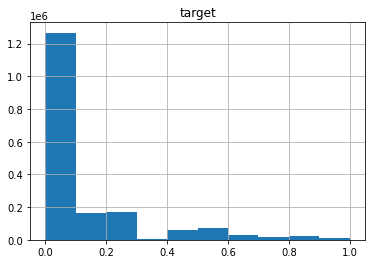

In [19]:
train_df.hist(column='target',bins=10)

In [20]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

**No Null values for target and comment_text columns**

In [23]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


## Exploratory Data Analysis:

### 1. Target Feature:

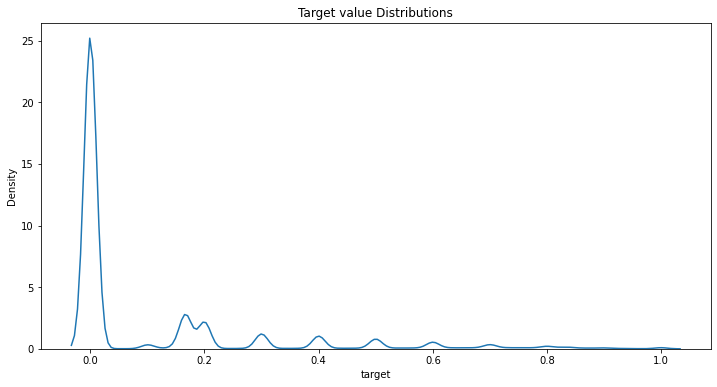

In [24]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

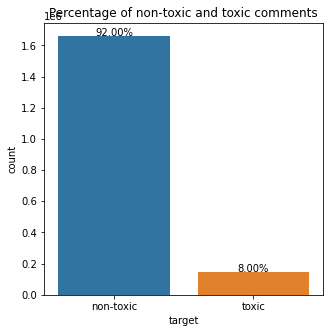

In [43]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

### 2. Toxicity Subtype Features:
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [46]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit according to my needs
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

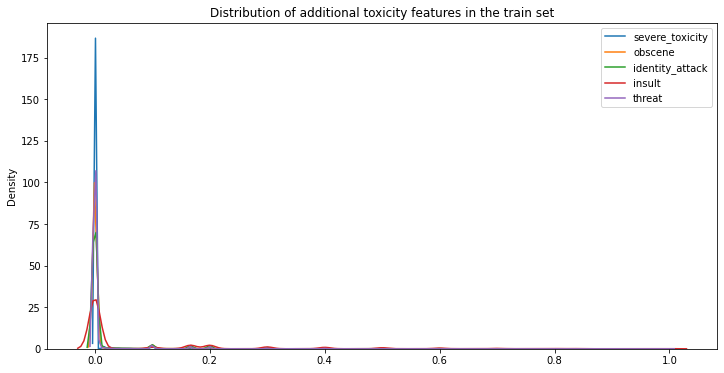

In [47]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

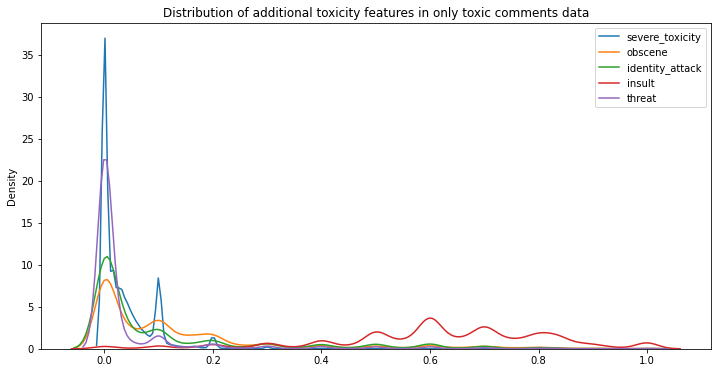

In [48]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [51]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

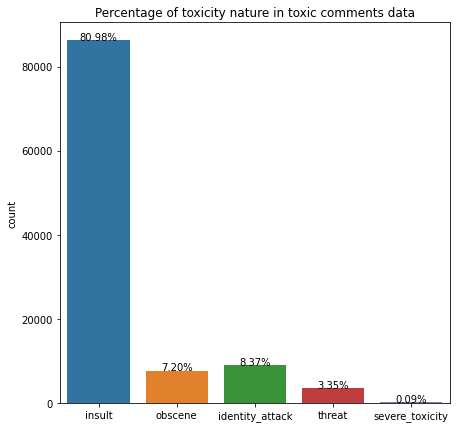

In [62]:
x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    # print('p.get_x()-----',p.get_x())
    # print('p.get_width()-----',p.get_width())
    # print('p.get_width()/2-----',p.get_width()/2.0)
    # print('p.get_x() + p.get_width()/2.0=======================',p.get_x() + p.get_width()/2.0)
    # print('height + 3====>>>>',height + 3)
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
plt.show()

**In our train dataset only 8% of the data was toxic. Out of that 8%, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic.**

### 3. Identity Attributes:

Sensitive topics:

- male
- female
- homosexual_gay_or_lesbian
- bisexual
- heterosexual
- christian
- jewish
- muslim
- black
- white
- asian
- latino

In [63]:
temp = train_df.dropna(axis = 0, how = 'any')

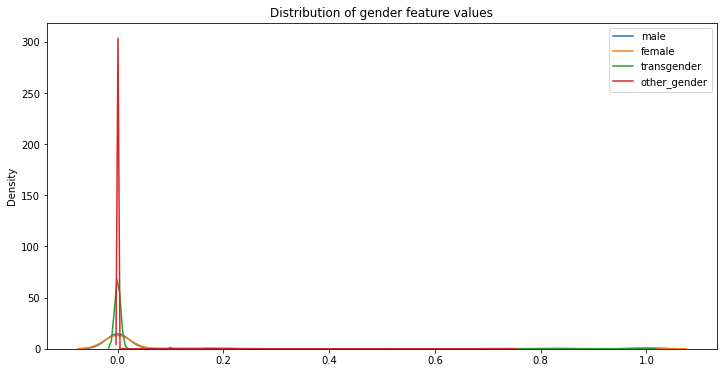

In [64]:
features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

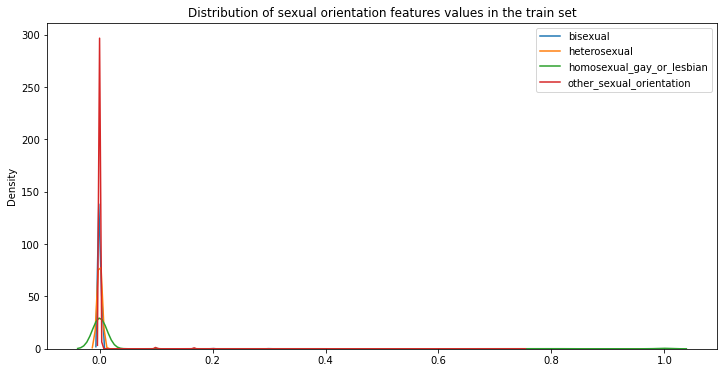

In [65]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

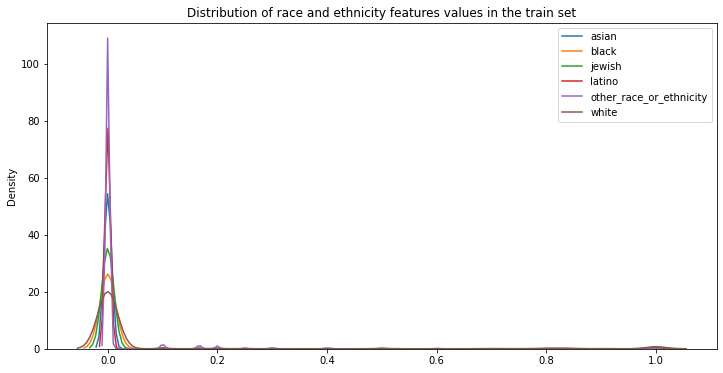

In [66]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

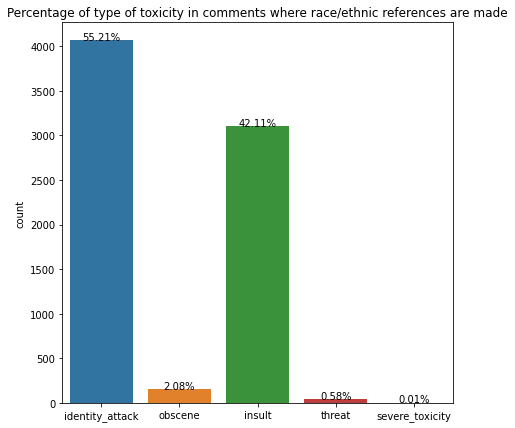

In [68]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
# print('cond========================',cond)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

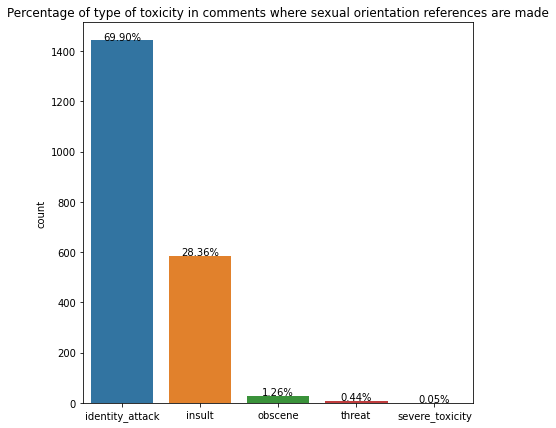

In [71]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.** 

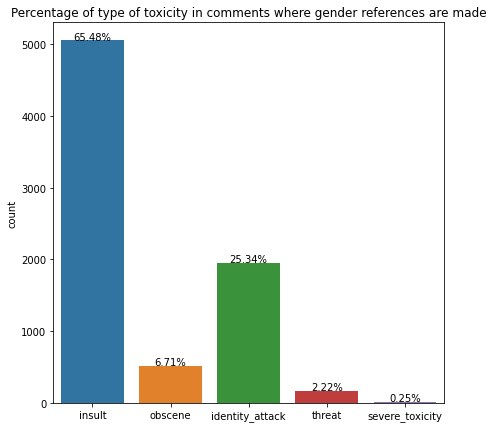

In [25]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

### 4. Features generated by users feedback:

- funny
- sad
- wow
- likes
- disagree

In [80]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

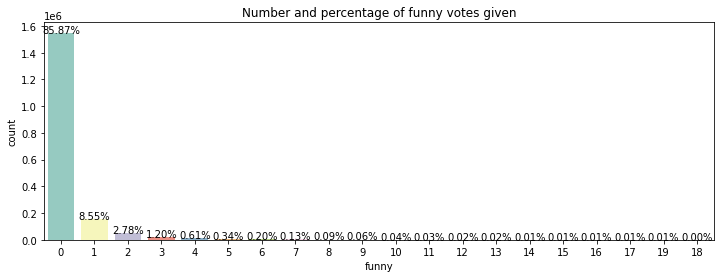

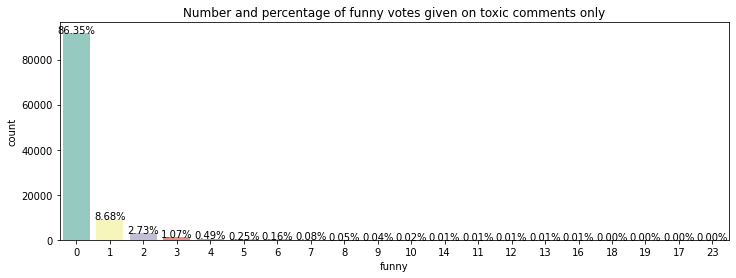

In [82]:
plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

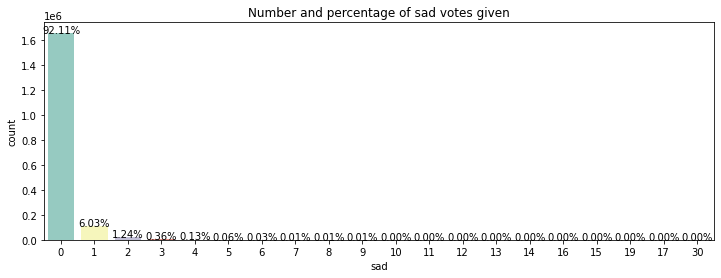

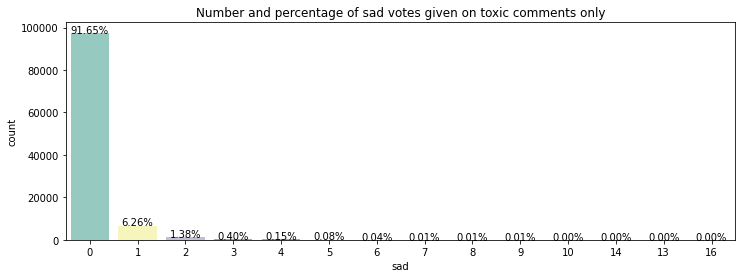

In [86]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

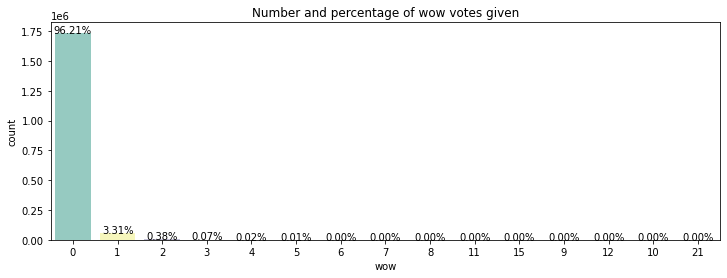

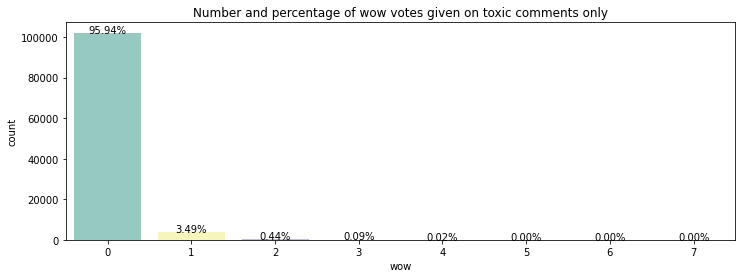

In [87]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

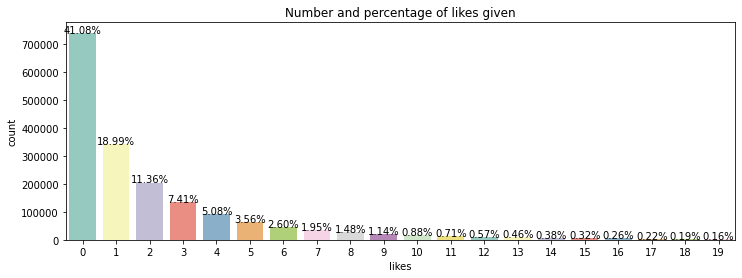

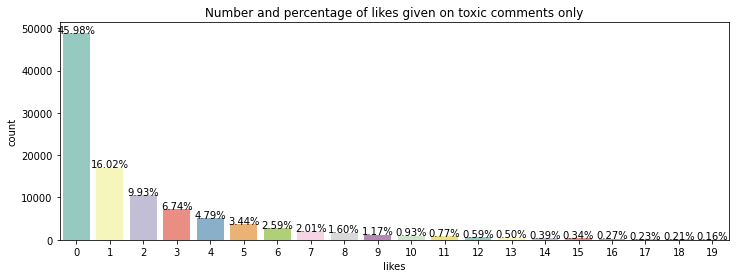

In [89]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

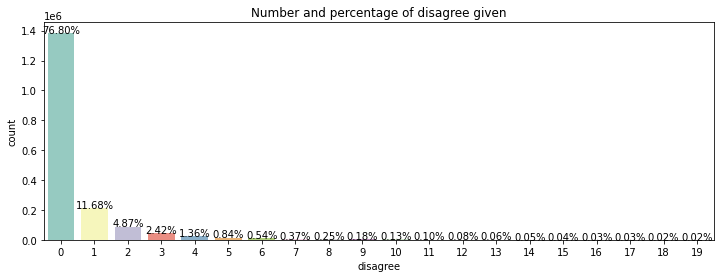

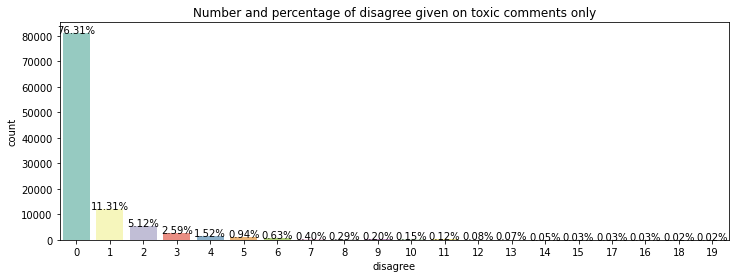

In [90]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

### 5. Comments_text Feature:

In [91]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

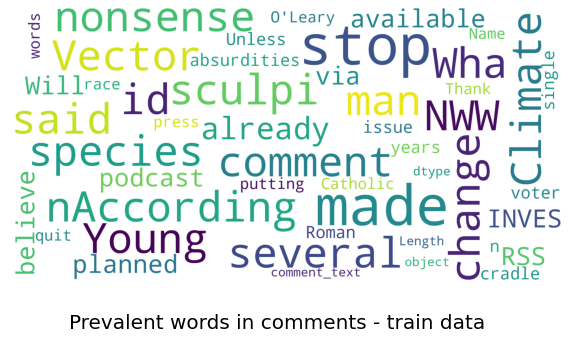

In [93]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

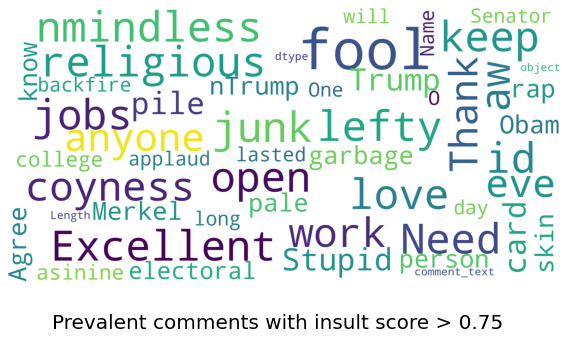

In [94]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

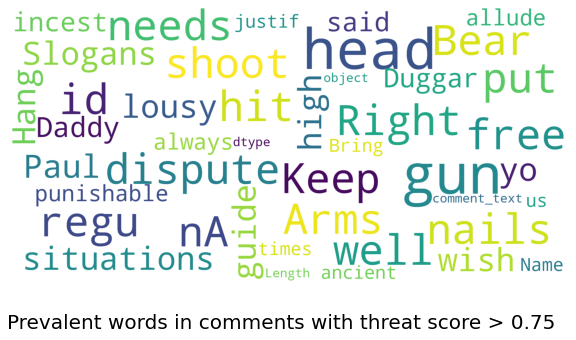

In [95]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

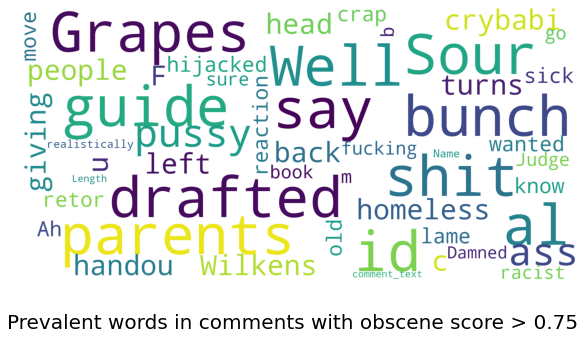

In [96]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

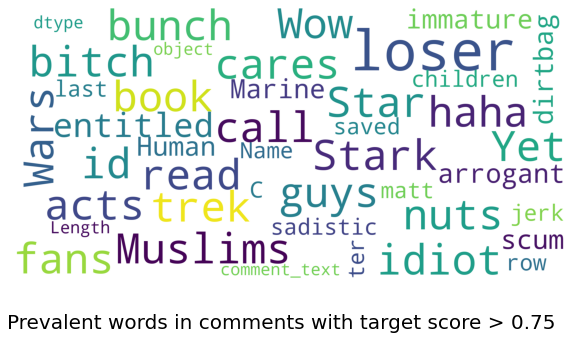

In [97]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

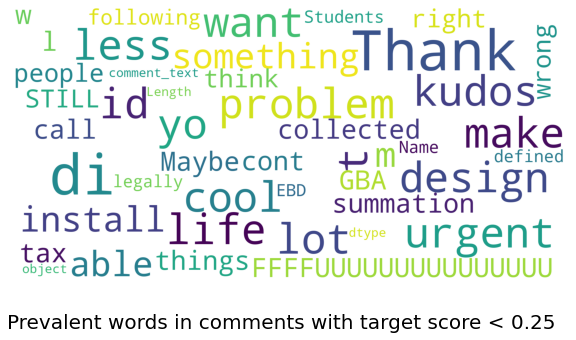

In [98]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

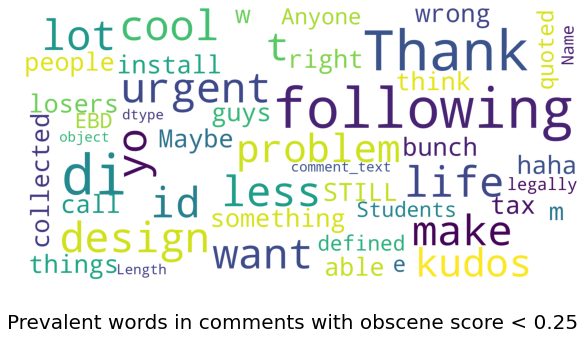

In [99]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

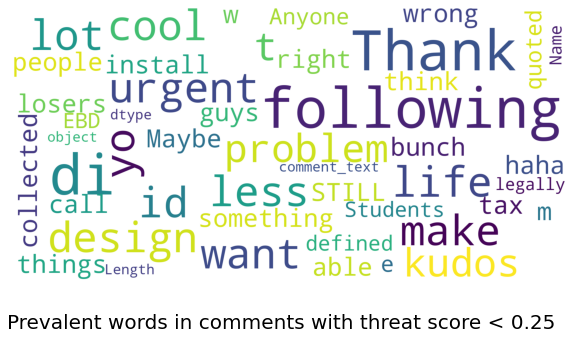

In [100]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

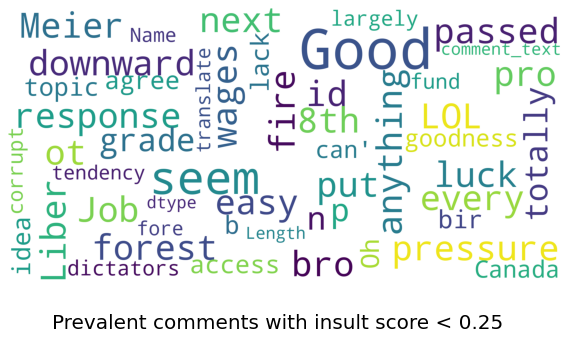

In [101]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

## Preprocessing Text and Train-Test Split:

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/harsh.vardhan/codebasics/vn/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [102]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [103]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

KeyboardInterrupt: 

In [13]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [14]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: user 1min 8s, sys: 566 µs, total: 1min 8s
Wall time: 1min 8s


In [15]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [16]:
X_train.head()

,preprocessed_text
id,
5120902,oceanbuoy respons interest understand present ...
1072661,agre
5636731,topic true thread courag convers therapi battl...
5733679,ken bet hee plan polit comeback dead pleas
790884,coz know whole thing go collaps soon


In [17]:
X_cv.head()

,preprocessed_text
id,
5461195,appar involv iron multipl dp articl complain
5188178,pan think jealous
5535397,gomer need coach identifi fact hold honourari ...
5077871,hey true conserv take okay right
261751,mr carey excel commentari encourag read observ...


In [18]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [6]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('./data/X_train.pkl')
X_cv.to_pickle('./data/X_cv.pkl')
X_test.to_pickle('./data/X_test.pkl')
y_train.to_pickle('./data/y_train.pkl')
y_cv.to_pickle('./data/y_cv.pkl')

# X_train.to_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/X_train.pkl')
# X_cv.to_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/X_cv.pkl')
# X_test.to_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/X_test.pkl')
# y_train.to_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/y_train.pkl')
# y_cv.to_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/y_cv.pkl')

NameError: name 'X_train' is not defined

## Training Models:

In [104]:
# To load the csv files:
# Uncomment the block.

X_train = pd.read_pickle('./data/X_train.pkl')
X_cv = pd.read_pickle('./data/X_cv.pkl')
X_test = pd.read_pickle('./data/X_test.pkl')
y_train = pd.read_pickle('./data/y_train.pkl')
y_cv = pd.read_pickle('./data/y_cv.pkl')

# X_train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/X_train.pkl')
# X_cv = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/X_cv.pkl')
# X_test = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/X_test.pkl')
# y_train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/y_train.pkl')
# y_cv = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/y_cv.pkl')

### 1. Bag of Words (BoW):

In [105]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 1.1 SGDRegressor:

##### 1.1.1 Hyperparameter Tuning:

In [106]:
y_train

,target
id,
5120902,0.000000
1072661,0.000000
5636731,0.000000
5733679,0.166667
790884,0.166667
...,...
6050163,0.000000
6052358,0.500000
972708,0.000000


In [109]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.6662704600463346
Mean Squared Error on cv set:  0.05931615247362735
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.5762323576538032
Mean Squared Error on cv set:  0.04809711396039412
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.024505630956035366
Mean Squared Error on cv set:  0.024419893374588796
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.3100431212537316
Mean Squared Error on cv set:  0.03596008991798987
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03146179727301771
Mean Squared Error on cv set:  0.03141798167544046
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.055730925309573444
Mean Squared Error on cv set:  0.0299297991708127
************************************************

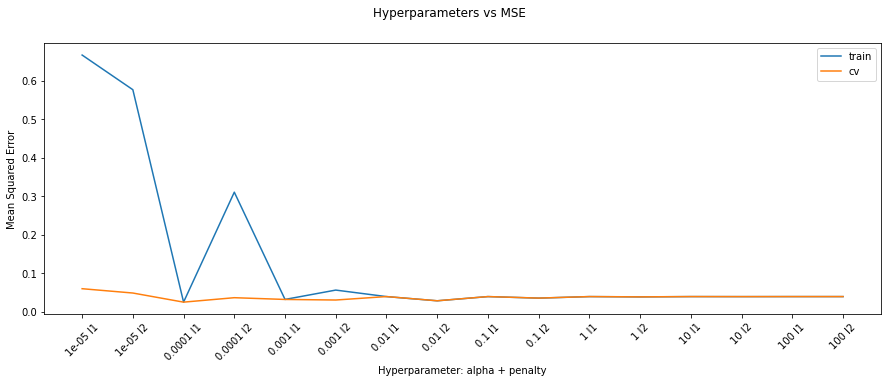

In [110]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [111]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [59]:
##### 1.1.2 Feature Importance:

In [112]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.422558
stupid,0.347888
moron,0.300713
pathet,0.294528
crap,0.275959
hypocrit,0.260461
dumb,0.247739
ass,0.238242
clown,0.223112
fool,0.212367


In [115]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.014431
white hous,-0.011742
agre,-0.009965
http,-0.009794
year,-0.009569
https,-0.009013
point,-0.008690
correct,-0.008523
com,-0.008513
issu,-0.008394


#### 1.2 Decision Trees:

##### 1.2.1 Hyperparameter Tuning:

In [116]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.033117019996529336
Mean Squared Error on cv set:  0.03307466020946821
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03311701999652935
Mean Squared Error on cv set:  0.03307466020946821
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03311930278566583
Mean Squared Error on cv set:  0.0330759689330737
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03202694513582513
Mean Squared Error on cv set:  0.03204044813068191
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03203127467622132
Mean Squared Error on cv set:  0.032034392867278376
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train

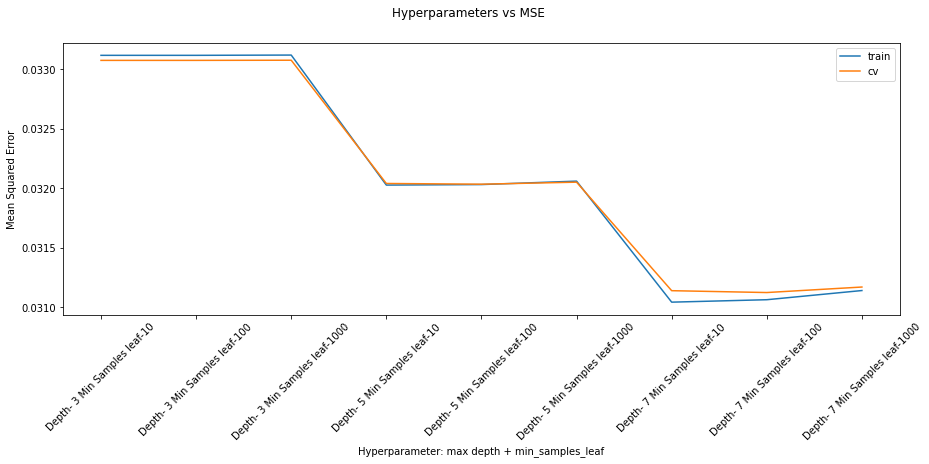

In [117]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [65]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### 1.2.2 Feature Importance:

In [118]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.395544
idiot,0.263127
pathet,0.071210
fool,0.069002
moron,0.064137
racist,0.060450
hypocrit,0.055572
would,0.003891
year,0.003732
one,0.003509


### 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [119]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 2.1 SGDRegressor:

##### 2.1.1 Hyperparameter Tuning:


In [120]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.025270042311163195
Mean Squared Error on cv set:  0.02527621507705402
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.02390901742449238
Mean Squared Error on cv set:  0.023964194222986467
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.0297305137669705
Mean Squared Error on cv set:  0.02973899226049008
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.02502025495120486
Mean Squared Error on cv set:  0.025078923088705386
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03828461048989006
Mean Squared Error on cv set:  0.038348619296090354
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.030050845120735317
Mean Squared Error on cv set:  0.030120200650177863
******************************************

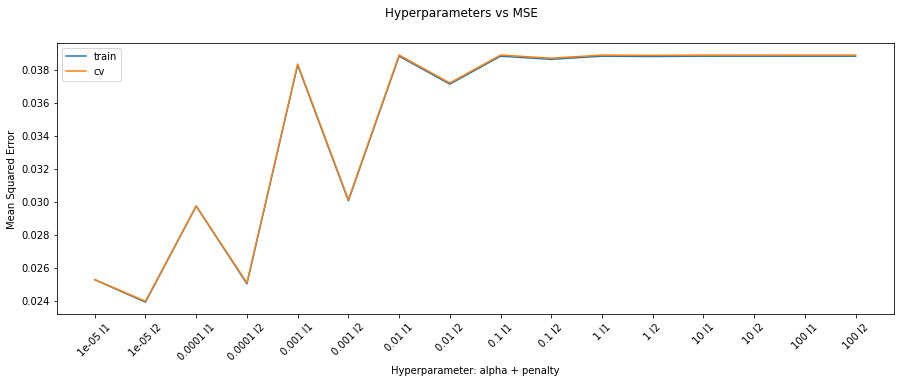

In [121]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.1.2 Feature Importance:

In [122]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.560431
idiot,1.262129
fool,0.662023
ignor,0.610579
pathet,0.595865
dumb,0.593475
moron,0.574258
ridicul,0.567267
loser,0.556993
hypocrit,0.513784


In [123]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.094184
interest,-0.086527
agre,-0.078440
stori,-0.076734
great,-0.073013
may,-0.069539
point,-0.069315
new,-0.067985
good,-0.067951
com,-0.067846


#### 2.2 Decision Trees:

##### 2.2.1 Hyperparameter Tuning:

In [132]:
tfidf_train[0]
mydf = pd.DataFrame(tfidf_train)
mydf.head()

,0
0,"(0, 394)\t0.09170078789626607\n (0, 400)\t0..."
1,"(0, 932)\t1.0"
2,"(0, 600)\t0.16897452102342825\n (0, 1161)\t..."
3,"(0, 2645)\t0.304041093091214\n (0, 4843)\t0..."
4,"(0, 4695)\t0.36902351984147147\n (0, 9929)\..."


In [124]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03290916384494835
Mean Squared Error on cv set:  0.032880580887607876
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.032909163844948346
Mean Squared Error on cv set:  0.03288058088760787
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03290916384494835
Mean Squared Error on cv set:  0.03288058088760788
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03176080365529951
Mean Squared Error on cv set:  0.03178266776706353
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.031761472520873094
Mean Squared Error on cv set:  0.03178259703122896
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on tra

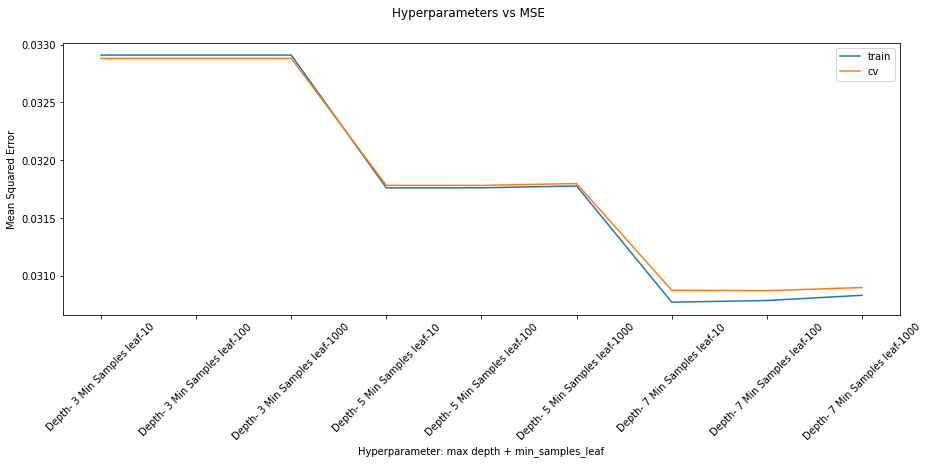

In [125]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.2.2 Feature Importance:

In [126]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.405506
idiot,0.267232
pathet,0.073326
fool,0.072382
moron,0.064668
racist,0.058506
hypocrit,0.053921
white,0.002019
trump,0.000662
peopl,0.000407


### 3. Features for LSTM:

In [8]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        # whole = tf.keras.preprocessing.sequence.pad_sequences(np.array([whole]), maxlen=pad_length)
        whole = tf.keras.preprocessing.sequence.pad_sequences(whole, maxlen=pad_length)

        
        return whole

In [18]:
X_train['preprocessed_text'][727817]

'would anyon hire mr harreus full background check would seen work record know good employe job support peopl blue blind bad thing lawsuit happen'

In [151]:
sent2 = "would anyon hire mr harreus full background check would seen work record know good employe job support peopl blue blind bad thing lawsuit happen"

In [131]:
sent = "oh look russian troll back board"

In [9]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [153]:
whole = list() # Stores mapping for all sentences
# for x in sentences: # for each sentence in list of sentences.
part = list()
for word in sent.split(): # for each word
    if word in lstmfeat.word_mapping:
        part.append(lstmfeat.word_mapping[word]) # Append mapped number.
whole.append(part) # Append sentence.

In [156]:
part = list()
for word in sent2.split(): # for each word
    if word in lstmfeat.word_mapping:
        part.append(lstmfeat.word_mapping[word]) # Append mapped number.
whole.append(part) # Append sentence.

In [154]:
part

[314, 39, 410, 1201, 42, 603]

In [155]:
whole

[[314, 39, 410, 1201, 42, 603]]

In [171]:
len(whole[1])

24

In [159]:
pad_length = 350

In [ ]:
whole2 = tf.keras.preprocessing.sequence.pad_sequences(whole, maxlen=pad_length)

In [ ]:
tf.keras.utils.pad_sequences(whole,maxlen=pad_length)

In [173]:
tf.keras.preprocessing.sequence.pad_sequences(whole,maxlen=pad_length)


array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0, 

In [124]:
lstmfeat.word_mapping

{'peopl': 1,
 'would': 2,
 'like': 3,
 'one': 4,
 'get': 5,
 'trump': 6,
 'year': 7,
 'go': 8,
 'time': 9,
 'make': 10,
 'think': 11,
 'us': 12,
 'need': 13,
 'right': 14,
 'know': 15,
 'state': 16,
 'say': 17,
 'want': 18,
 'tax': 19,
 'good': 20,
 'use': 21,
 'mani': 22,
 'work': 23,
 'even': 24,
 'see': 25,
 'govern': 26,
 'way': 27,
 'take': 28,
 'well': 29,
 'much': 30,
 'thing': 31,
 'could': 32,
 'pay': 33,
 'money': 34,
 'countri': 35,
 'come': 36,
 'vote': 37,
 'also': 38,
 'look': 39,
 'live': 40,
 'support': 41,
 'back': 42,
 'never': 43,
 'canada': 44,
 'law': 45,
 'person': 46,
 'realli': 47,
 'tri': 48,
 'comment': 49,
 'call': 50,
 'fact': 51,
 'said': 52,
 'point': 53,
 'day': 54,
 'chang': 55,
 'elect': 56,
 'public': 57,
 'new': 58,
 'let': 59,
 'world': 60,
 'problem': 61,
 'still': 62,
 'job': 63,
 'presid': 64,
 'first': 65,
 'care': 66,
 'polit': 67,
 'liber': 68,
 'actual': 69,
 'american': 70,
 'noth': 71,
 'believ': 72,
 'better': 73,
 'mean': 74,
 'everi': 75,

In [125]:
lstmfeat.total_words

201566

In [10]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [24]:
np.save('./data/lstm_train.npy', lstm_train)
np.save('./data/lstm_cv.npy', lstm_cv)
np.save('./data/lstm_test.npy', lstm_test)

# np.save('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/lstm_train.npy', lstm_train)
# np.save('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/lstm_cv.npy', lstm_cv)
# np.save('/content/drive/MyDrive/Colab Notebooks/Toxic-Comments-Classification/data/lstm_test.npy', lstm_test)

In [11]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

2023-02-27 22:08:00.465487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-27 22:08:00.474932: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-27 22:08:00.475019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (IBS-LAP-278): /proc/driver/nvidia/version does not exist
2023-02-27 22:08:00.495959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          20115700  
                                                                 
 lstm (LSTM)                 (None, 350, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20,364,661
Trainable params: 20,364,661
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# history = model.fit(lstm_train, y_train, epochs=5,
#                     batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

history = model.fit(lstm_train, y_train, epochs=1,validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

In [ ]:
# history = model.fit(lstm_train, y_train, epochs=5)

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

## Conclusions:



1. **BagOfWords:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02281
        - CV MSE Loss: 0.02326
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.0310
        - CV MSE Loss: 0.03128
2. **TFIDF:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02556
        - CV MSE Loss: 0.02584
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.03073
        - CV MSE Loss: 0.03122
3. **LSTM:**
    - Train MSE Loss: 0.0157
    - CV MSE Loss: 0.0162